In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dir = "/kaggle/input/fish-dataset/FishImgDataset/train"
val_dir = "/kaggle/input/fish-dataset/FishImgDataset/val"
test_dir = "/kaggle/input/fish-dataset/FishImgDataset/test"

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_data = datasets.ImageFolder(root=val_dir, transform=transform_test)
test_data = datasets.ImageFolder(root=test_dir, transform=transform_test)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

num_classes = len(train_data.classes)
model = CNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




Using device: cuda


In [22]:
def train_model(model, train_loader, val_loader, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)
        
        model.eval()
        val_running_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_running_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(val_correct / val_total)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    
    return train_loss, val_loss, train_acc, val_acc

epochs = 10
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs)


Epoch 1/10, Train Loss: 0.7388, Train Acc: 0.7741, Val Loss: 0.3601, Val Acc: 0.9171
Epoch 2/10, Train Loss: 0.6922, Train Acc: 0.7835, Val Loss: 0.3307, Val Acc: 0.9208
Epoch 3/10, Train Loss: 0.6683, Train Acc: 0.7954, Val Loss: 0.3244, Val Acc: 0.9211
Epoch 4/10, Train Loss: 0.6555, Train Acc: 0.7956, Val Loss: 0.3273, Val Acc: 0.9204
Epoch 5/10, Train Loss: 0.6372, Train Acc: 0.7980, Val Loss: 0.2764, Val Acc: 0.9298
Epoch 6/10, Train Loss: 0.6276, Train Acc: 0.8094, Val Loss: 0.2569, Val Acc: 0.9393
Epoch 7/10, Train Loss: 0.6010, Train Acc: 0.8101, Val Loss: 0.2533, Val Acc: 0.9393
Epoch 8/10, Train Loss: 0.5705, Train Acc: 0.8258, Val Loss: 0.2529, Val Acc: 0.9397
Epoch 9/10, Train Loss: 0.5531, Train Acc: 0.8199, Val Loss: 0.2351, Val Acc: 0.9462
Epoch 10/10, Train Loss: 0.5420, Train Acc: 0.8308, Val Loss: 0.2464, Val Acc: 0.9455


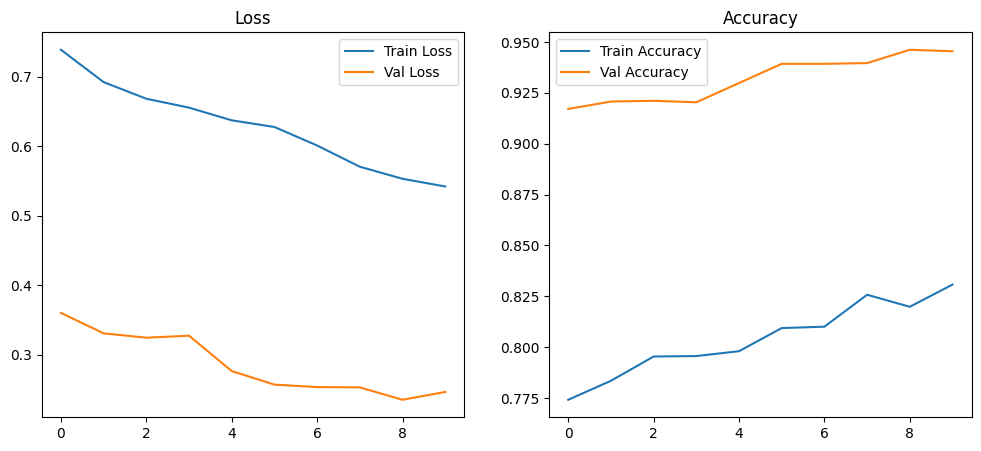


Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.85      0.85      0.85        34
        Big Head Carp       0.88      0.88      0.88        43
   Black Spotted Barb       0.92      0.88      0.90        40
              Catfish       0.91      0.85      0.88        62
       Climbing Perch       1.00      0.80      0.89        30
 Fourfinger Threadfin       0.90      0.95      0.92        38
       Freshwater Eel       0.90      0.84      0.87        55
       Glass Perchlet       0.93      0.91      0.92        77
                 Goby       0.91      0.92      0.92       124
            Gold Fish       0.98      1.00      0.99        41
              Gourami       1.00      0.98      0.99        63
           Grass Carp       0.97      0.99      0.98       238
 Green Spotted Puffer       0.91      0.91      0.91        22
          Indian Carp       0.94      0.96      0.95        53
  Indo-Pacific Tarpon       0.

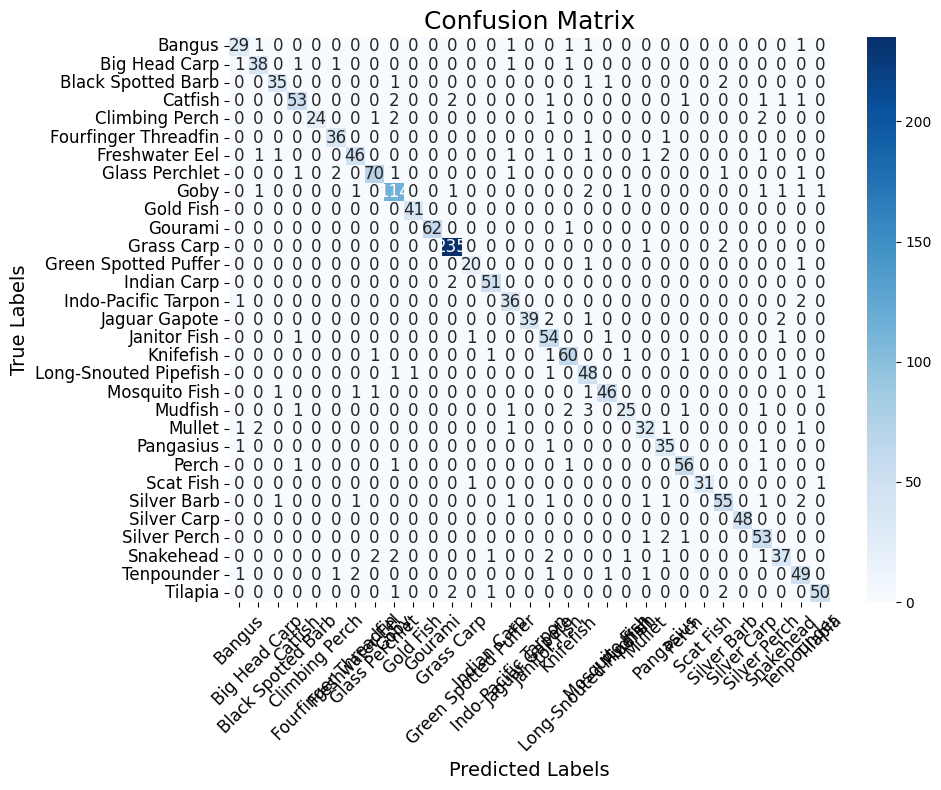

Overall ROC-AUC: 0.9941771560485833


In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")


plt.show()

model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_data.classes))

import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=train_data.classes, yticklabels=train_data.classes, 
            annot_kws={"size": 12})  

plt.title("Confusion Matrix", fontsize=18)  
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.xticks(fontsize=12, rotation=45)  
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

y_true_one_hot = np.eye(num_classes)[y_true]
roc_auc = roc_auc_score(y_true_one_hot, y_scores, multi_class="ovo")
print("Overall ROC-AUC:", roc_auc)


In [4]:
model_save_path = "customCNN_fish.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to customCNN_fish.pth


Predicted Class: Climbing Perch


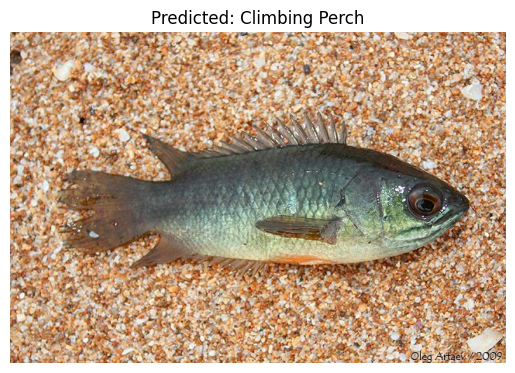

In [11]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')  
    image = transform(image)  
    image = image.unsqueeze(0)  
    return image.to(device)

def predict_image(image_path, model, transform, class_names):
    model.eval()  
    with torch.no_grad():
        image = preprocess_image(image_path, transform)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

transform_single_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

uploaded_image_path = "/kaggle/input/fish-dataset/FishImgDataset/test/Climbing Perch/Climbing perch 008.jpg"  # Replace with your image path

predicted_class = predict_image(uploaded_image_path, model, transform_single_image, train_data.classes)
print(f"Predicted Class: {predicted_class}")

image = Image.open(uploaded_image_path)
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}")
plt.show()
